 # Question 3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Flatten, Input, Dense, SimpleRNN, GRU, LSTM, Dropout, Activation, BatchNormalization, LayerNormalization, Dropout
from keras import initializers, regularizers, optimizers, backend

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Activation, BatchNormalization, Dropout
from keras import initializers, regularizers, optimizers, backend




In [6]:
# cleaning out the NaNs
# this will be loading in the regression dataset
# Replace 'your_file.csv' with the path to your CSV file
file_path = 'data/Air_pollution.csv'

# Use pandas to read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# taking out the nessesary data
new_df = df[['month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']]

# dropping out the NaN numbers i guess
new_df = new_df.dropna()

# data preprocessing
# using default values + month, since that was what worked best i guess
asset_input = pd.DataFrame(new_df, columns=['month', 'DEWP', 'TEMP', 'PRES', 'Iws'])
x_all = asset_input.values

asset_output = pd.DataFrame(new_df, columns=['pm2.5'])
y_all = asset_output.values

# finding out the length of the dataset, and then getting the first 90% as the data i guess
splits = int(0.9 * x_all.shape[0])

timestep = 200

# training sample if i am not mistaken
x_real = x_all[0:splits, :]
y_real = y_all[0:splits, :]

# testing samples
x_test_real = x_all[splits-timestep:, :]
y_test_real = y_all[splits-timestep:, :]

# scaling the samples accordingly
# most of them fall within a range, and has min and max value, and as such, normalization is choosen i guess
# Normalization
scaler_x = MinMaxScaler()
scaler_x.fit(x_real)
x_scale = scaler_x.transform(x_real)

scaler_y = MinMaxScaler()
scaler_y.fit(y_real)
y_scale = scaler_y.transform(y_real)

In [7]:
# # generating training and validation datasets using timeseries generator
# # Try out the time series generator
# column1 = np.arange(1,51)
# column2 = np.arange(1,51)
# data = np.column_stack((column1, column2))
# targets = np.arange(1,51)
# data_generator = TimeseriesGenerator(data, targets, length=5, sampling_rate=1, batch_size=2)
# a, b = data_generator[0]
# print(a)
# print(b)

# setting up the training and validation dataset
data_generator = TimeseriesGenerator(x_scale, y_scale, length=timestep, sampling_rate=1, batch_size=10000)
x_timestep, y_timestep = data_generator[0]

x_train, x_val, y_train, y_val = train_test_split(x_timestep, y_timestep, test_size=0.1, random_state=7567)


# generating the testing data as well i guess
x_test_scale = scaler_x.transform(x_test_real)
y_test_scale = scaler_y.transform(y_test_real)

data_generator = TimeseriesGenerator(x_test_scale, y_test_scale, length=timestep, sampling_rate=1, batch_size=10000)
x_test, y_test = data_generator[0]

 # artificial neural network

In [22]:
# will be using default + month, since that was what that worked best for everything else
backend.clear_session()
init_weight = initializers.GlorotUniform(seed=7567)
regu_weight = regularizers.l2(0.01)

model = Sequential()
model.add(Flatten(input_shape=(timestep,5)))
model.add(Dense(100, kernel_initializer=init_weight, kernel_regularizer=regu_weight))
model.add(BatchNormalization())
model.add(Activation('ReLU'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer=init_weight, kernel_regularizer=regu_weight))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 100)               5100      
                                                                 
 batch_normalization (Batch  (None, 100)               400       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                        

In [23]:
my_optmz = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=my_optmz, loss='mean_squared_error', metrics='mse')
model_hist = model.fit(x_train, y_train, epochs=20, batch_size=64, validation_data=(x_test,y_test), verbose=1)

Epoch 1/20
141/141 [==============================] - 3s 5ms/step - loss: 0.7581 - mse: 0.2188 - val_loss: 0.4183 - val_mse: 0.0092
Epoch 2/20
141/141 [==============================] - 1s 4ms/step - loss: 0.4253 - mse: 0.0993 - val_loss: 0.2676 - val_mse: 0.0116
Epoch 3/20
141/141 [==============================] - 0s 3ms/step - loss: 0.2574 - mse: 0.0500 - val_loss: 0.1756 - val_mse: 0.0107
Epoch 4/20
141/141 [==============================] - 0s 3ms/step - loss: 0.1634 - mse: 0.0294 - val_loss: 0.1160 - val_mse: 0.0092
Epoch 5/20
141/141 [==============================] - 0s 3ms/step - loss: 0.1048 - mse: 0.0179 - val_loss: 0.0754 - val_mse: 0.0058
Epoch 6/20
141/141 [==============================] - 0s 3ms/step - loss: 0.0685 - mse: 0.0117 - val_loss: 0.0574 - val_mse: 0.0120
Epoch 7/20
141/141 [==============================] - 0s 3ms/step - loss: 0.0457 - mse: 0.0086 - val_loss: 0.0399 - val_mse: 0.0101
Epoch 8/20
141/141 [==============================] - 0s 3ms/step - loss: 0.

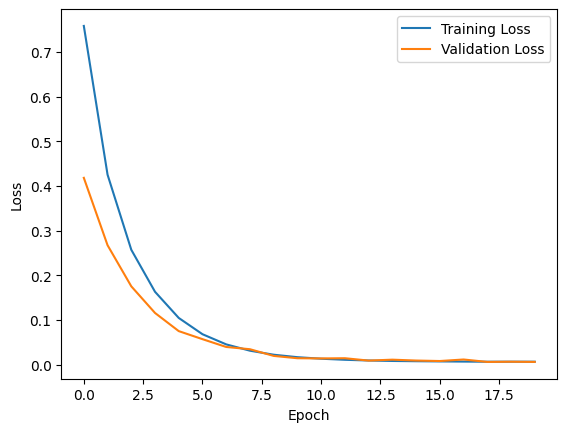

In [24]:
plt.figure()
plt.plot(model_hist.history['loss'], label='Training Loss')
plt.plot(model_hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
y_test_pred_scale = model.predict(x_test, verbose=0)
mse_test_scale = mean_squared_error(y_test, y_test_pred_scale)

y_test_pred_real = scaler_y.inverse_transform(y_test_pred_scale)
mse_test_real = mean_squared_error(y_test_real[timestep:,0], y_test_pred_real)

print("Mean squared error of the scaled testing dataset:", mse_test_scale)
print("Mean squared error of the real testing dataset (USD):", mse_test_real)

Mean squared error of the scaled testing dataset: 0.005721355337919863
Mean squared error of the real testing dataset (USD): 5652.905056550391


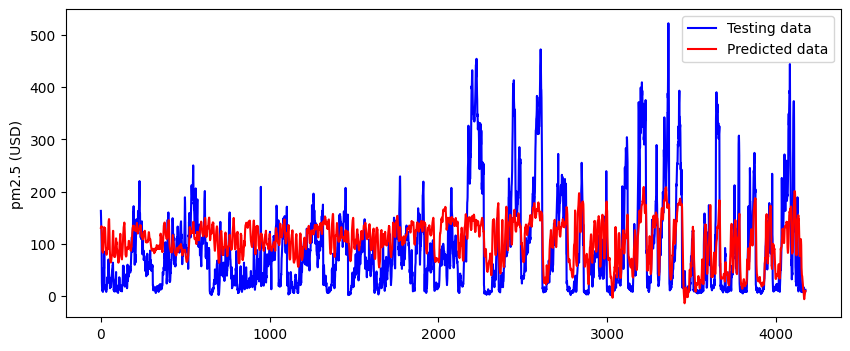

In [26]:
plt.figure(figsize=(10,4))
plt.plot(y_test_real[timestep:,0], color='blue', label='Testing data')
plt.plot(y_test_pred_real, color='red', label='Predicted data')
plt.ylabel('pm2.5 (USD)')
plt.legend()
plt.show()

In [45]:
# looping it through the timesteps i guess
timestep_list = [10, 50, 100, 200]
mse_train_list = []
mse_val_list = []
mse_test_list = []

for timestep in timestep_list:
    print(f'starting of timestep {timestep}')
    # training sample if i am not mistaken
    x_real = x_all[0:splits, :]
    y_real = y_all[0:splits, :]

    # testing samples
    x_test_real = x_all[splits-timestep:, :]
    y_test_real = y_all[splits-timestep:, :]

    # scaling the samples accordingly
    # most of them fall within a range, and has min and max value, and as such, normalization is choosen i guess
    # Normalization
    scaler_x = MinMaxScaler()
    scaler_x.fit(x_real)
    x_scale = scaler_x.transform(x_real)

    scaler_y = MinMaxScaler()
    scaler_y.fit(y_real)
    y_scale = scaler_y.transform(y_real)

    # setting up the training and validation dataset
    data_generator = TimeseriesGenerator(x_scale, y_scale, length=timestep, sampling_rate=1, batch_size=10000)
    x_timestep, y_timestep = data_generator[0]

    x_train, x_val, y_train, y_val = train_test_split(x_timestep, y_timestep, test_size=0.1, random_state=7567)


    # generating the testing data as well i guess
    x_test_scale = scaler_x.transform(x_test_real)
    y_test_scale = scaler_y.transform(y_test_real)

    data_generator = TimeseriesGenerator(x_test_scale, y_test_scale, length=timestep, sampling_rate=1, batch_size=10000)
    x_test, y_test = data_generator[0]

    backend.clear_session()
    init_weight = initializers.GlorotUniform(seed=7567)
    regu_weight = regularizers.l2(0.01)

    model = Sequential()
    model.add(Flatten(input_shape=(timestep,5)))
    model.add(Dense(100, kernel_initializer=init_weight, kernel_regularizer=regu_weight))
    model.add(BatchNormalization())
    model.add(Activation('ReLU'))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer=init_weight, kernel_regularizer=regu_weight))

    my_optmz = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=my_optmz, loss='mean_squared_error', metrics='mse')
    model_hist = model.fit(x_train, y_train, epochs=20, batch_size=64, validation_data=(x_test,y_test), verbose=0)

    # predict the train and validation as well i guess


    y_test_pred_scale = model.predict(x_test, verbose=0)
    mse_test_scale = mean_squared_error(y_test, y_test_pred_scale)

    y_test_pred_real = scaler_y.inverse_transform(y_test_pred_scale)
    mse_test_real = mean_squared_error(y_test_real[timestep:,0], y_test_pred_real)


    mse_train_list.append(model_hist.history['mse'][-1])
    mse_val_list.append(model_hist.history['val_mse'][-1])
    # grabbing the scaled mse
    mse_test_list.append(mse_test_scale)

    print(f'timestep of {timestep}')
    print("Mean squared error of the scaled testing dataset:", mse_test_scale)
    print("Mean squared error of the real testing dataset (USD):", mse_test_real)

print(mse_train_list)
print(mse_val_list)
print(mse_test_list)

starting of timestep 10
timestep of 10
Mean squared error of the scaled testing dataset: 0.008907500885309462
Mean squared error of the real testing dataset (USD): 8800.931543099281
starting of timestep 50
timestep of 50
Mean squared error of the scaled testing dataset: 0.010341086196646601
Mean squared error of the real testing dataset (USD): 10217.36544591085
starting of timestep 100
timestep of 100
Mean squared error of the scaled testing dataset: 0.02073192563041929
Mean squared error of the real testing dataset (USD): 20483.888841370084
starting of timestep 200
timestep of 200
Mean squared error of the scaled testing dataset: 0.008184230498211773
Mean squared error of the real testing dataset (USD): 8086.314356369527
[0.006044862791895866, 0.006141415797173977, 0.006065987050533295, 0.0063732885755598545]
[0.008907502517104149, 0.01034108828753233, 0.020731927827000618, 0.008184230886399746]
[0.008907500885309462, 0.010341086196646601, 0.02073192563041929, 0.008184230498211773]


 # recurrent neural network

In [35]:
backend.clear_session()
init_weight = initializers.GlorotUniform(seed=0)
regu_weight = regularizers.l2(0.001)

model = Sequential()
model.add(Input(shape=(timestep,5)))
model.add(SimpleRNN(100, activation='tanh', return_sequences=False, kernel_initializer=init_weight, kernel_regularizer=regu_weight, recurrent_dropout=0))
#model.add(LayerNormalization()) #optional, default activation must be changed to None
#model.add(Activation('tanh')) #separately apply activation function if using layer normalization
model.add(Dense(1, kernel_initializer=init_weight, kernel_regularizer=regu_weight))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100)               10600     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 10701 (41.80 KB)
Trainable params: 10701 (41.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [36]:
my_optmz = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=my_optmz, loss='mean_squared_error', metrics='mse')
model_hist = model.fit(x_train, y_train, epochs=20, batch_size=64, validation_data=(x_val,y_val), verbose=1)

Epoch 1/20
141/141 [==============================] - 3s 6ms/step - loss: 0.0421 - mse: 0.0314 - val_loss: 0.0207 - val_mse: 0.0103
Epoch 2/20
141/141 [==============================] - 1s 4ms/step - loss: 0.0182 - mse: 0.0081 - val_loss: 0.0206 - val_mse: 0.0109
Epoch 3/20
141/141 [==============================] - 1s 4ms/step - loss: 0.0169 - mse: 0.0076 - val_loss: 0.0172 - val_mse: 0.0082
Epoch 4/20
141/141 [==============================] - 1s 5ms/step - loss: 0.0157 - mse: 0.0071 - val_loss: 0.0161 - val_mse: 0.0078
Epoch 5/20
141/141 [==============================] - 1s 4ms/step - loss: 0.0148 - mse: 0.0069 - val_loss: 0.0155 - val_mse: 0.0079
Epoch 6/20
141/141 [==============================] - 1s 4ms/step - loss: 0.0144 - mse: 0.0071 - val_loss: 0.0152 - val_mse: 0.0082
Epoch 7/20
141/141 [==============================] - 1s 4ms/step - loss: 0.0133 - mse: 0.0067 - val_loss: 0.0141 - val_mse: 0.0078
Epoch 8/20
141/141 [==============================] - 1s 4ms/step - loss: 0.

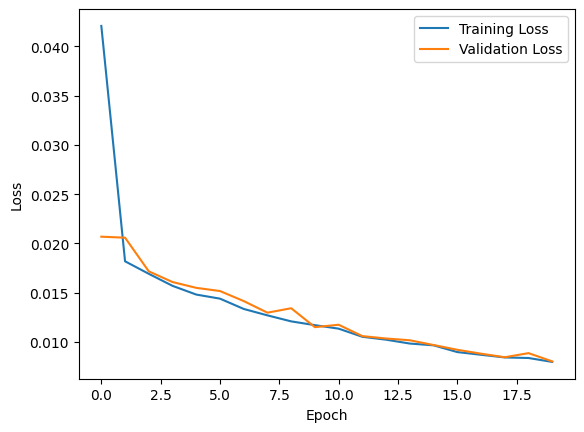

In [37]:
plt.figure()
plt.plot(model_hist.history['loss'], label='Training Loss')
plt.plot(model_hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [38]:
y_test_pred_scale = model.predict(x_test, verbose=0)
mse_test_scale = mean_squared_error(y_test, y_test_pred_scale)

y_test_pred_real = scaler_y.inverse_transform(y_test_pred_scale)
mse_test_real = mean_squared_error(y_test_real[timestep:,0], y_test_pred_real)

print("Mean squared error of the scaled testing dataset:", mse_test_scale)
print("Mean squared error of the real testing dataset (USD):", mse_test_real)

Mean squared error of the scaled testing dataset: 0.0063052516175815245
Mean squared error of the real testing dataset (USD): 6229.815591432918


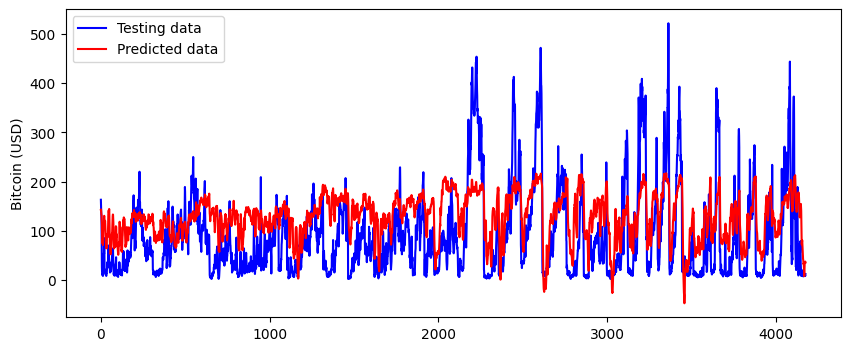

In [39]:
plt.figure(figsize=(10,4))
plt.plot(y_test_real[timestep:,0], color='blue', label='Testing data')
plt.plot(y_test_pred_real, color='red', label='Predicted data')
plt.ylabel('Bitcoin (USD)')
plt.legend()
plt.show()

In [46]:
# this will be looping over the timestep stuff i guess
timestep_list = [10, 50, 100, 200]
mse_train_list = []
mse_val_list = []
mse_test_list = []

for timestep in timestep_list:
    print(f'starting of timestep {timestep}')
    # training sample if i am not mistaken
    x_real = x_all[0:splits, :]
    y_real = y_all[0:splits, :]

    # testing samples
    x_test_real = x_all[splits-timestep:, :]
    y_test_real = y_all[splits-timestep:, :]

    # scaling the samples accordingly
    # most of them fall within a range, and has min and max value, and as such, normalization is choosen i guess
    # Normalization
    scaler_x = MinMaxScaler()
    scaler_x.fit(x_real)
    x_scale = scaler_x.transform(x_real)

    scaler_y = MinMaxScaler()
    scaler_y.fit(y_real)
    y_scale = scaler_y.transform(y_real)

    # setting up the training and validation dataset
    data_generator = TimeseriesGenerator(x_scale, y_scale, length=timestep, sampling_rate=1, batch_size=10000)
    x_timestep, y_timestep = data_generator[0]

    x_train, x_val, y_train, y_val = train_test_split(x_timestep, y_timestep, test_size=0.1, random_state=7567)


    # generating the testing data as well i guess
    x_test_scale = scaler_x.transform(x_test_real)
    y_test_scale = scaler_y.transform(y_test_real)

    data_generator = TimeseriesGenerator(x_test_scale, y_test_scale, length=timestep, sampling_rate=1, batch_size=10000)
    x_test, y_test = data_generator[0]

    backend.clear_session()
    init_weight = initializers.GlorotUniform(seed=7567)
    regu_weight = regularizers.l2(0.001)

    model = Sequential()
    model.add(Input(shape=(timestep,5)))
    model.add(SimpleRNN(100, activation='tanh', return_sequences=False, kernel_initializer=init_weight, kernel_regularizer=regu_weight, recurrent_dropout=0))
    #model.add(LayerNormalization()) #optional, default activation must be changed to None
    #model.add(Activation('tanh')) #separately apply activation function if using layer normalization
    model.add(Dense(1, kernel_initializer=init_weight, kernel_regularizer=regu_weight))

    my_optmz = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=my_optmz, loss='mean_squared_error', metrics='mse')
    model_hist = model.fit(x_train, y_train, epochs=30, batch_size=64, validation_data=(x_val,y_val), verbose=0)

    y_test_pred_scale = model.predict(x_test, verbose=0)
    mse_test_scale = mean_squared_error(y_test, y_test_pred_scale)

    y_test_pred_real = scaler_y.inverse_transform(y_test_pred_scale)
    mse_test_real = mean_squared_error(y_test_real[timestep:,0], y_test_pred_real)

    mse_train_list.append(model_hist.history['mse'][-1])
    mse_val_list.append(model_hist.history['val_mse'][-1])
    # grabbing the scaled mse
    mse_test_list.append(mse_test_scale)
    print("Mean squared error of the scaled testing dataset:", mse_test_scale)
    print("Mean squared error of the real testing dataset (USD):", mse_test_real)
print(mse_train_list)
print(mse_val_list)
print(mse_test_list)

starting of timestep 10


KeyboardInterrupt: 

# Gated recurrent neural network

In [ ]:
# this will be looping over the timestep stuff i guess
timestep_list = [10, 50, 100, 200]
mse_list = []

for timestep in timestep_list:
    print(f'starting of timestep {timestep}')
    # training sample if i am not mistaken
    x_real = x_all[0:splits, :]
    y_real = y_all[0:splits, :]

    # testing samples
    x_test_real = x_all[splits-timestep:, :]
    y_test_real = y_all[splits-timestep:, :]

    # scaling the samples accordingly
    # most of them fall within a range, and has min and max value, and as such, normalization is choosen i guess
    # Normalization
    scaler_x = MinMaxScaler()
    scaler_x.fit(x_real)
    x_scale = scaler_x.transform(x_real)

    scaler_y = MinMaxScaler()
    scaler_y.fit(y_real)
    y_scale = scaler_y.transform(y_real)

    # setting up the training and validation dataset
    data_generator = TimeseriesGenerator(x_scale, y_scale, length=timestep, sampling_rate=1, batch_size=10000)
    x_timestep, y_timestep = data_generator[0]

    x_train, x_val, y_train, y_val = train_test_split(x_timestep, y_timestep, test_size=0.1, random_state=7567)


    # generating the testing data as well i guess
    x_test_scale = scaler_x.transform(x_test_real)
    y_test_scale = scaler_y.transform(y_test_real)

    data_generator = TimeseriesGenerator(x_test_scale, y_test_scale, length=timestep, sampling_rate=1, batch_size=10000)
    x_test, y_test = data_generator[0]

    backend.clear_session()
    init_weight = initializers.GlorotUniform(seed=7567)
    regu_weight = regularizers.l2(0.001)

    backend.clear_session()
    model = Sequential()
    model.add(Input(shape=(timestep,5)))
    model.add(GRU(100, activation='tanh', recurrent_activation='sigmoid', return_sequences=False, kernel_initializer=init_weight, kernel_regularizer=regu_weight))
    model.add(Dense(1, kernel_initializer=init_weight, kernel_regularizer=regu_weight))


    my_optmz = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=my_optmz, loss='mean_squared_error', metrics='mse')
    model_hist = model.fit(x_train, y_train, epochs=20, batch_size=64, validation_data=(x_val,y_val), verbose=0)

    y_test_pred_scale = model.predict(x_test, verbose=0)
    mse_test_scale = mean_squared_error(y_test, y_test_pred_scale)

    y_test_pred_real = scaler_y.inverse_transform(y_test_pred_scale)
    mse_test_real = mean_squared_error(y_test_real[timestep:,0], y_test_pred_real)

    mse_train_list.append(model_hist.history['mse'][-1])
    mse_val_list.append(model_hist.history['val_mse'][-1])
    # grabbing the scaled mse
    mse_test_list.append(mse_test_scale)
    print("Mean squared error of the scaled testing dataset:", mse_test_scale)
    print("Mean squared error of the real testing dataset (USD):", mse_test_real)
print(mse_train_list)
print(mse_val_list)
print(mse_test_list)

 # LSTM

In [47]:
# this will be looping over the timestep stuff i guess
timestep_list = [10, 50, 100, 200]
mse_train_list = []
mse_val_list = []
mse_test_list = []

for timestep in timestep_list:
    print(f'starting of timestep {timestep}')
    # training sample if i am not mistaken
    x_real = x_all[0:splits, :]
    y_real = y_all[0:splits, :]

    # testing samples
    x_test_real = x_all[splits-timestep:, :]
    y_test_real = y_all[splits-timestep:, :]

    # scaling the samples accordingly
    # most of them fall within a range, and has min and max value, and as such, normalization is choosen i guess
    # Normalization
    scaler_x = MinMaxScaler()
    scaler_x.fit(x_real)
    x_scale = scaler_x.transform(x_real)

    scaler_y = MinMaxScaler()
    scaler_y.fit(y_real)
    y_scale = scaler_y.transform(y_real)

    # setting up the training and validation dataset
    data_generator = TimeseriesGenerator(x_scale, y_scale, length=timestep, sampling_rate=1, batch_size=10000)
    x_timestep, y_timestep = data_generator[0]

    x_train, x_val, y_train, y_val = train_test_split(x_timestep, y_timestep, test_size=0.1, random_state=7567)


    # generating the testing data as well i guess
    x_test_scale = scaler_x.transform(x_test_real)
    y_test_scale = scaler_y.transform(y_test_real)

    data_generator = TimeseriesGenerator(x_test_scale, y_test_scale, length=timestep, sampling_rate=1, batch_size=10000)
    x_test, y_test = data_generator[0]

    backend.clear_session()
    init_weight = initializers.GlorotUniform(seed=7567)
    regu_weight = regularizers.l2(0.001)

    model = Sequential()
    model.add(Input(shape=(timestep,5)))
    model.add(LSTM(100, activation='tanh', recurrent_activation='sigmoid', return_sequences=False, kernel_initializer=init_weight, kernel_regularizer=regu_weight))
    model.add(Dense(1, kernel_initializer=init_weight, kernel_regularizer=regu_weight))

    my_optmz = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=my_optmz, loss='mean_squared_error', metrics='mse')
    model_hist = model.fit(x_train, y_train, epochs=20, batch_size=64, validation_data=(x_val,y_val), verbose=0)

    y_test_pred_scale = model.predict(x_test, verbose=0)
    mse_test_scale = mean_squared_error(y_test, y_test_pred_scale)

    y_test_pred_real = scaler_y.inverse_transform(y_test_pred_scale)
    mse_test_real = mean_squared_error(y_test_real[timestep:,0], y_test_pred_real)

    mse_train_list.append(model_hist.history['mse'][-1])
    mse_val_list.append(model_hist.history['val_mse'][-1])
    # grabbing the scaled mse
    mse_test_list.append(mse_test_scale)
    print("Mean squared error of the scaled testing dataset:", mse_test_scale)
    print("Mean squared error of the real testing dataset (USD):", mse_test_real)
print(mse_train_list)
print(mse_val_list)
print(mse_test_list)

starting of timestep 10
Mean squared error of the scaled testing dataset: 0.005846956649136268
Mean squared error of the real testing dataset (USD): 5777.003659281809
starting of timestep 50
Mean squared error of the scaled testing dataset: 0.005307628419000359
Mean squared error of the real testing dataset (USD): 5244.127955493197
starting of timestep 100
Mean squared error of the scaled testing dataset: 0.00516794398642002
Mean squared error of the real testing dataset (USD): 5106.114714545923
starting of timestep 200


KeyboardInterrupt: 